# Explore here

It's recommended to use this notebook for exploration purposes.

In [1]:
pip install pandas requests lxml


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io


In [3]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table", class_="wikitable")
headers = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]


In [4]:
rows = []
for tr in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True) for td in tr.find_all(["td", "th"])]
    if len(cells) == len(headers):
        rows.append(cells)

In [6]:
df = pd.DataFrame(rows, columns=headers)

df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)

df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

df["Streams (billions)"] = df["Streams (billions)"].astype(float)

df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

In [7]:
conn = sqlite3.connect("spotify_top_songs.db")
df.to_sql("most_streamed", conn, if_exists="replace", index=False)

100

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM most_streamed")

conn.commit()
conn.close()

Rows inserted: 100


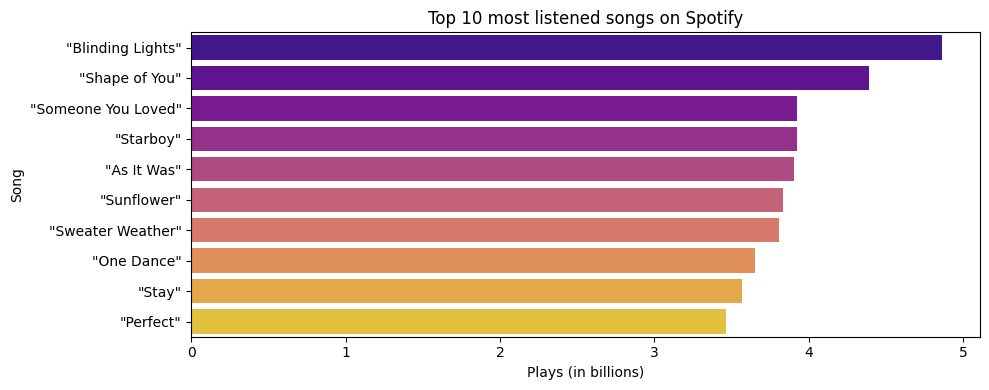

In [13]:
top10 = df.nlargest(10, "Streams (billions)")
plt.figure(figsize=(10, 4))
sns.barplot(data=top10, x="Streams (billions)", y="Song", hue="Song", palette="plasma", legend=False)
plt.title("Top 10 most listened songs on Spotify")
plt.xlabel("Plays (in billions)")
plt.ylabel("Song")
plt.tight_layout()
plt.show()

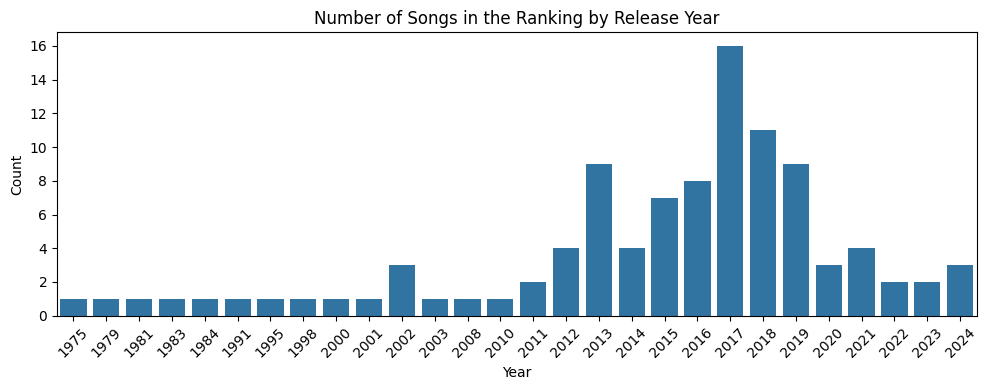

In [15]:
df["Year"] = df["Date released"].dt.year
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()))
plt.title("Number of Songs in the Ranking by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

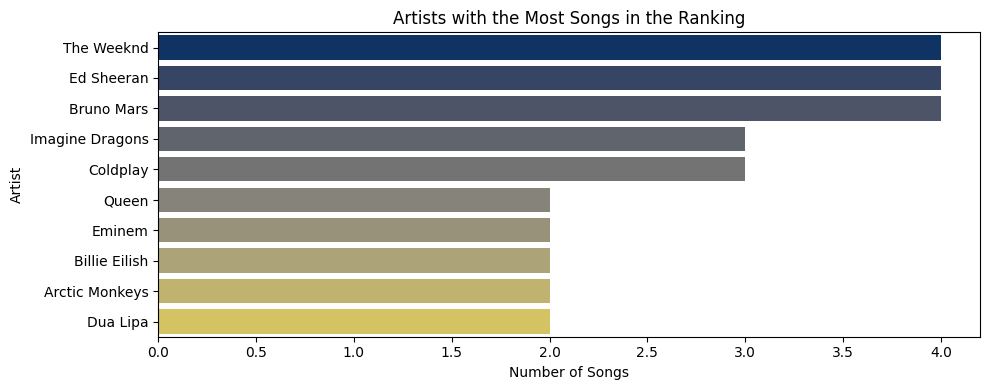

In [17]:
artists = df["Artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=artists.values, y=artists.index, hue=artists.index, palette="cividis", legend=False)
plt.title("Artists with the Most Songs in the Ranking")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()